# "End-to-end Pytorch model in five minutes"
> "Standardising dataloaders, model, training and validation - so you don't have to"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, pytorch, cnn, computer vision]
- hide: false
- search_exclude: true

In [20]:
# hide
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Download and import data
All datasets are subclasses of `torch.utils.data.Dataset`; that is, they have `_len_` and `_getitem_` methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel.

In [3]:
data_path = '/Users/charlesoneill/DataspellProjects/pytorch'

In [4]:
kmnist = datasets.KMNIST(data_path, train=True, download=True,
                       transform = transforms.Compose([
                           transforms.ToTensor()]))
kmnist_val = datasets.KMNIST(data_path, train=False, download=True,
                           transform = transforms.ToTensor())

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw/train-images-idx3-ubyte.gz to /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw/train-labels-idx1-ubyte.gz to /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/charlesoneill/DataspellProjects/pytorch/KMNIST/raw



In [6]:
# find the normalisation values
# we stack all the tensors along an extra dimension
imgs = torch.stack([img_t for img_t, _ in kmnist], dim=3)
imgs.shape

torch.Size([1, 28, 28, 60000])

In [7]:
# compute mean per channel
imgs.view(1,-1).mean(dim=1) 
# view (1,-1) keeps the three channels and merges
# remaining dimensions into one

tensor([0.1918])

In [8]:
# compute std per channel
imgs.view(1,-1).std(dim=1)

tensor([0.3483])

In [9]:
# normalised data
t_kmnist = datasets.KMNIST(data_path, train=True,
                                       download=False, transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307),
                                                                (0.3081))
                                       ]))

t_kmnist_val = datasets.KMNIST(data_path, train=False,
                                           download=False, transform=transforms.Compose([
                                               transforms.ToTensor()]))

In [10]:
train_loader = torch.utils.data.DataLoader(kmnist, batch_size=100,
                                           shuffle=True,
                                           num_workers=1)
val_loader = torch.utils.data.DataLoader(kmnist_val, batch_size=100,
                                         shuffle=False,
                                         num_workers=1)

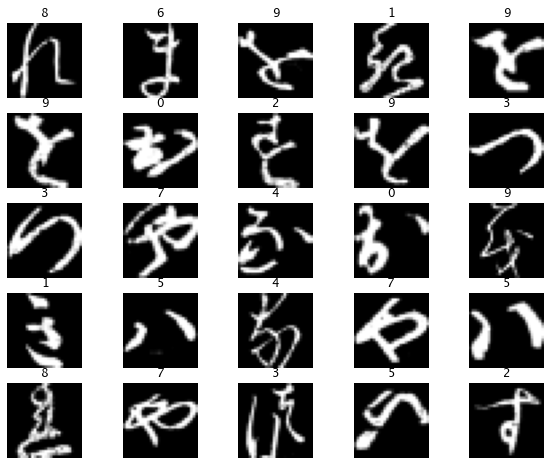

In [21]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(t_kmnist), size=(1,)).item()
    img, label = t_kmnist[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [11]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [12]:
img, _ = next(iter(train_loader))
img = img[0]
img.shape

torch.Size([1, 28, 28])

In [13]:
model = Net()
model(img.unsqueeze(0)).shape

torch.Size([1, 10])

## Training

In [14]:
import datetime

def training_loop(n_epochs, model, loss_fn, optimiser, train_loader):
    model.train()
    total_step = len(train_loader)
    for n in range(1, n_epochs+1):
        loss_train = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(imgs)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)
            loss = loss_fn(output, b_y)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            loss_train += loss.item()

            if (i+1) % 100 == 0:
                print ('{} Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(datetime.datetime.now(), n, n_epochs, 
                               i + 1, total_step, loss.item()))

In [15]:
model = Net()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [16]:
training_loop(
    n_epochs = 10,
    model = model,
    loss_fn = loss_fn,
    optimiser = optimiser,
    train_loader = train_loader
)

2022-02-02 15:01:20.745283 Epoch [1/10], Step [100/600], Loss: 0.0501
2022-02-02 15:01:27.340855 Epoch [1/10], Step [200/600], Loss: 0.2209
2022-02-02 15:01:33.839873 Epoch [1/10], Step [300/600], Loss: 0.2408
2022-02-02 15:01:40.275823 Epoch [1/10], Step [400/600], Loss: 0.2765
2022-02-02 15:01:46.689798 Epoch [1/10], Step [500/600], Loss: 0.0957
2022-02-02 15:01:53.095480 Epoch [1/10], Step [600/600], Loss: 0.1274
2022-02-02 15:02:00.255035 Epoch [2/10], Step [100/600], Loss: 0.1320
2022-02-02 15:02:06.675968 Epoch [2/10], Step [200/600], Loss: 0.0391
2022-02-02 15:02:13.103217 Epoch [2/10], Step [300/600], Loss: 0.2103
2022-02-02 15:02:19.532527 Epoch [2/10], Step [400/600], Loss: 0.1154
2022-02-02 15:02:26.066319 Epoch [2/10], Step [500/600], Loss: 0.0381
2022-02-02 15:02:32.541000 Epoch [2/10], Step [600/600], Loss: 0.0589
2022-02-02 15:02:39.966782 Epoch [3/10], Step [100/600], Loss: 0.0508
2022-02-02 15:02:46.835930 Epoch [3/10], Step [200/600], Loss: 0.0403
2022-02-02 15:02:53.

## Validate

In [17]:
def validate(model, train_loader, val_loader):       
    # Test the model
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in val_loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test Accuracy of the model on the test images: %.2f' % accuracy)

In [18]:
validate(model, train_loader, val_loader)

Test Accuracy of the model on the test images: 0.93
